In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG import Data
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

In [2]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_full = discretize.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0']
)

# Add air resistivity
res_h_full = 1e8*np.ones(mesh_full.vnC)
res_v_full = 1e8*np.ones(mesh_full.vnC)
res_h_full[:, :, :-1] = tres_h
res_v_full[:, :, :-1] = tres_v
del data, tres_h, tres_v

mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

Text(0.5, 1.0, 'rho_v')

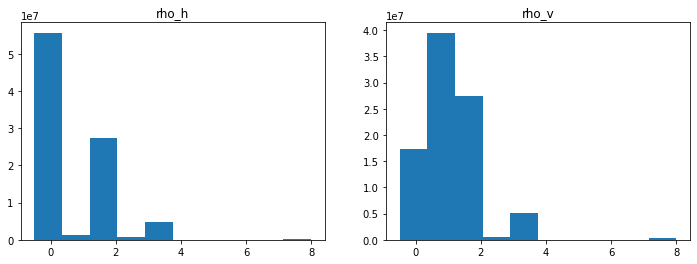

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

histh = ax[0].hist(np.log10(mkvc(res_h_full)), 10);
histv = ax[1].hist(np.log10(mkvc(res_v_full)), 10);

# ax[0].set_xlim([-1, 1])
# ax[1].set_xlim([-1, 1])

ax[0].set_title("rho_h")
ax[1].set_title("rho_v")

In [4]:
10**histh[1][0]

0.3199999928474426

In [5]:
10**histh[1][1]

2.262741654278355

In [6]:
10**histh[1][1] - 10**histh[1][0]

1.9427416614309125

In [7]:
np.min(np.log10(res_h_full)), np.min(np.log10(res_v_full))

(-0.49485003138733225, -0.49485003138733225)

In [8]:
np.min(res_h_full), np.min(res_v_full)

(0.3199999928474426, 0.3199999928474426)

In [9]:
%%time
# compute the total gradient
dmdx_h = np.abs(mesh_full._cellGradxStencil * mkvc(res_h_full))
dmdy_h = np.abs(mesh_full._cellGradyStencil * mkvc(res_h_full))
dmdz_h = np.abs(mesh_full._cellGradzStencil * mkvc(res_h_full))

CPU times: user 22.1 s, sys: 13.2 s, total: 35.2 s
Wall time: 35.3 s


In [10]:
%%time
# compute the total gradient
dmdx_v = np.abs(mesh_full._cellGradxStencil * mkvc(res_v_full))
dmdy_v = np.abs(mesh_full._cellGradyStencil * mkvc(res_v_full))
dmdz_v = np.abs(mesh_full._cellGradzStencil * mkvc(res_v_full))

CPU times: user 20.8 s, sys: 12.9 s, total: 33.7 s
Wall time: 33.7 s


In [11]:
dmdx_h_nz = np.nonzero(dmdx_h)[0]
dmdy_h_nz = np.nonzero(dmdy_h)[0]
dmdz_h_nz = np.nonzero(dmdz_h)[0]

In [12]:
dmdx_v_nz = np.nonzero(dmdx_v)[0]
dmdy_v_nz = np.nonzero(dmdy_v)[0]
dmdz_v_nz = np.nonzero(dmdz_v)[0]

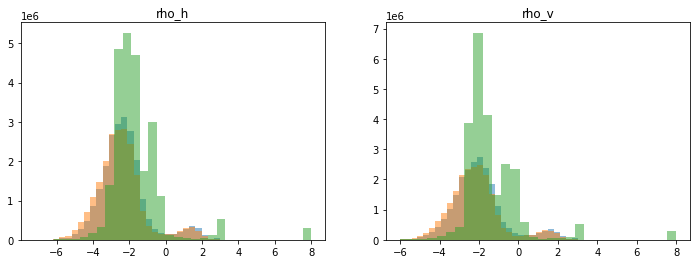

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for dim, h, v in zip(
    ["x", "y", "z"],
    [dmdx_h[dmdx_h_nz], dmdy_h[dmdy_h_nz], dmdz_h[dmdz_h_nz]],
    [dmdx_v[dmdx_v_nz], dmdy_v[dmdy_v_nz], dmdz_v[dmdz_v_nz]]
):

    ax[0].hist(np.log10(np.abs(mkvc(h))), 30, alpha=0.5);
    ax[1].hist(np.log10(np.abs(mkvc(v))), 30, alpha=0.5);

    ax[0].set_title("rho_h")
    ax[1].set_title("rho_v")

In [14]:
# average to cell centers and sum

dmdh = (
    mesh_full.aveFx2CC * dmdx_h + 
    mesh_full.aveFy2CC * dmdy_h + 
    mesh_full.aveFz2CC * dmdz_h
)

dmdv = (
    mesh_full.aveFx2CC * dmdx_v + 
    mesh_full.aveFy2CC * dmdy_v + 
    mesh_full.aveFz2CC * dmdz_v
)

In [15]:
dm = dmdh + dmdv

In [16]:
dm_nonzero = np.nonzero(dm)[0]

(array([8.0000000e+00, 1.8500000e+02, 3.2470000e+03, 3.0404000e+04,
        1.2459800e+05, 2.3574100e+05, 5.3933000e+05, 3.1231820e+06,
        5.4718920e+06, 1.3605903e+07, 7.4602590e+06, 7.8334060e+06,
        5.6419890e+06, 1.7179740e+06, 3.6301900e+05, 1.6212700e+05,
        2.9446200e+05, 6.2767800e+05, 4.8823100e+05, 1.2782330e+06,
        2.9898000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.7989000e+05]),
 array([-6.32162991, -5.84424225, -5.36685458, -4.88946692, -4.41207925,
        -3.93469159, -3.45730393, -2.97991626, -2.5025286 , -2.02514094,
        -1.54775327, -1.07036561, -0.59297795, -0.11559028,  0.36179738,
         0.83918504,  1.31657271,  1.79396037,  2.27134804,  2.7487357 ,
         3.22612336,  3.70351103,  4.18089869,  4.65828635,  5.13567402,
         5.61306168,  6.09044934,  6.56783701,  7.04522467,  7.52261234,
         8.        ]),
 <a list of 30 Patch ob

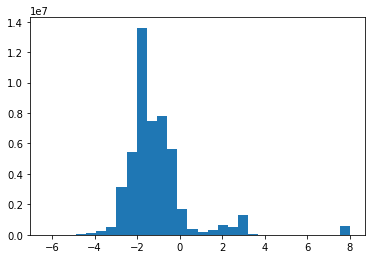

In [17]:
plt.hist(np.log10(dm[dm_nonzero]), 30)

In [18]:
threshold = 1
significant_dm = dm >= threshold

In [19]:
significant_dm.sum()

5040738

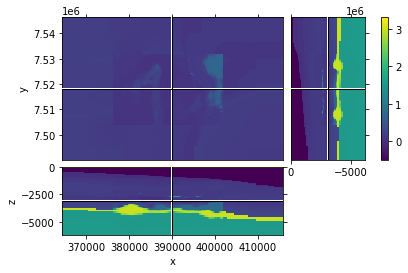

In [20]:
mesh_full.plot_3d_slicer(np.log10(res_h_full),  clim=[np.log10(0.32), np.log10(2000)])

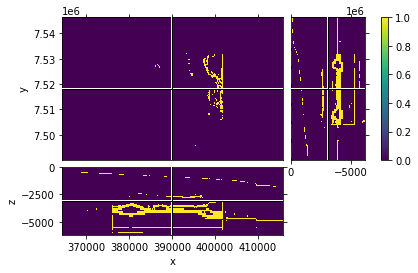

In [21]:
mesh_full.plot_3d_slicer(significant_dm)

## load survey info

In [22]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')

In [23]:
# Use reciprocity: rec becomes src
src = [
    ds.rec_x, ds.rec_y, ds.rec_z,
    ds.rec_theta, ds.rec_dip
]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

rec_locs_il = np.hstack([rec_x.data, np.ones_like(rec_x.data)*rec_y_il, rec_z_il]).T
rec_locs_bs = np.hstack([rec_x.data, np.ones_like(rec_x.data)*rec_y_bs, rec_z_bs]).T

# Frequency
freqs = ds.freqs.values

True


In [24]:
print(rec_x.max() - rec_x.min())
print(rec_y_il.max() - rec_y_il.min())
print(rec_y_bs.max() - rec_y_bs.min())
print(rec_z_il.max() - rec_z_il.min())
print(rec_z_bs.max() - rec_z_bs.min())

print(rec_z_bs.min(), rec_z_bs.max())
print(rec_z_il.min(), rec_z_il.max())

<xarray.DataArray 'src_x' ()>
array(21800., dtype=float32)
0.0
0.0
432.17328
429.44952
-1053.3586 -623.9091
-1034.6903 -602.517


In [25]:
# only refine in the core region where we are collecting data 

extra = 400. 

refine_points_core = significant_dm & (
    (mesh_full.gridCC[:, 0] > rec_x.data.min() - extra) &
    (mesh_full.gridCC[:, 0] < rec_x.data.max() + extra) & 
    (mesh_full.gridCC[:, 1] > rec_x.data.min()) &
    (mesh_full.gridCC[:, 1] > rec_x.data.max())
)

refine_points = mesh_full.gridCC[refine_points_core, :]

In [26]:
tmp = refine_points_core.nonzero()

In [27]:
tmp[0].shape

(3250017,)

In [28]:
significant_dm.nonzero()[0].shape

(5040738,)

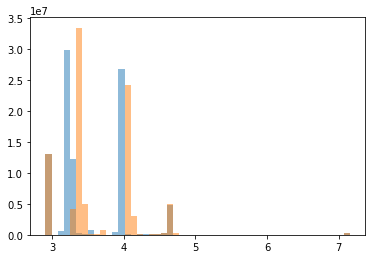

In [29]:
fig, ax = plt.subplots(1,1)
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_h_full))), 50, alpha=0.5);
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_v_full))), 50, alpha=0.5);

## design a mesh

In [30]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 200, 200, 80 

domain_x = float(rec_x.max() - rec_x.min())
domain_y = 0.4*domain_x 
domain_z = refine_points[:, 2].max() - refine_points[:, 2].min()

ncore_x = int(np.ceil(domain_x/dx))
ncore_y = int(np.ceil(domain_y/dy))
ncore_z = int(np.ceil(domain_z/dz))

print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

npad_x = 8
npad_y = 8
npad_z = 8

ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
ncy = 2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

print(ncx, ncy, ncz, ncx*ncy*ncz)

pf = 1.4


109 44 78 374088
128 64 128 1048576


In [31]:
mesh_full.x0

array([ 3.643250e+05,  7.490049e+06, -6.200000e+03])

In [32]:
mesh_full_center = np.r_[
    (mesh_full.gridCC[:, 0].min() + mesh_full.gridCC[:, 0].max())/2,
    (mesh_full.gridCC[:, 1].min() + mesh_full.gridCC[:, 1].max())/2,
    (mesh_full.gridCC[:, 2].min() + mesh_full.gridCC[:, 2].max())/2
]

In [33]:
# define the base mesh
mesh = discretize.TreeMesh(
    [
        [(dx, npad_x, -pf), (dx, ncx-npad_x*2), (dx, npad_x, pf)], 
        [(dy, npad_y, -pf), (dy, ncy-npad_y*2), (dy, npad_y, pf)], 
        [(dz, npad_z, -pf), (dz, ncz-npad_z*2), (dz, npad_z, pf)]
    ]
)

mesh.x0 = np.r_[
    -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2])/2.
] + mesh_full_center


# refine around the sources and receivers
src_refine = np.c_[src[0], src[1], src[2]]

mesh = discretize.utils.refine_tree_xyz(
    mesh, src_refine, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_il, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_bs, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

# refine around interesting surfaces
# this is currently not the best way to do this... 
# n_batches = 10
# n_values = np.ceil(refine_points.shape[0]/n_batches)
# for i in range(n_batches+1): 
#     inds = np.r_[int(i*n_values), int(np.min([(i+1)*n_values, refine_points.shape[0]]))]
#     print(i, inds)
mesh = discretize.utils.refine_tree_xyz(
    mesh, refine_points, 
    octree_levels=[1, 1], method="radial", finalize=False
)

mesh.finalize()

# return mesh

IndexError: Out of bounds on buffer access (axis 0)

In [34]:
mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

In [37]:
rec_locs_il

array([ 3.79375000e+05,  3.79475000e+05,  3.79575000e+05,  3.79675000e+05,
        3.79775000e+05,  3.79875000e+05,  3.79975000e+05,  3.80075000e+05,
        3.80175000e+05,  3.80275000e+05,  3.80375000e+05,  3.80475000e+05,
        3.80575000e+05,  3.80675000e+05,  3.80775000e+05,  3.80875000e+05,
        3.80975000e+05,  3.81075000e+05,  3.81175000e+05,  3.81275000e+05,
        3.81375000e+05,  3.81475000e+05,  3.81575000e+05,  3.81675000e+05,
        3.81775000e+05,  3.81875000e+05,  3.81975000e+05,  3.82075000e+05,
        3.82175000e+05,  3.82275000e+05,  3.82375000e+05,  3.82475000e+05,
        3.82575000e+05,  3.82675000e+05,  3.82775000e+05,  3.82875000e+05,
        3.82975000e+05,  3.83075000e+05,  3.83175000e+05,  3.83275000e+05,
        3.83375000e+05,  3.83475000e+05,  3.83575000e+05,  3.83675000e+05,
        3.83775000e+05,  3.83875000e+05,  3.83975000e+05,  3.84075000e+05,
        3.84175000e+05,  3.84275000e+05,  3.84375000e+05,  3.84475000e+05,
        3.84575000e+05,  

In [36]:
mesh.x0

array([ 369244.476608 , 7503768.476608 ,  -11422.2093568])

In [ ]:
mesh.save("./simpeg-marlim-mesh.json")

In [ ]:
fig, ax = plt.subplots(1, 1)
mesh.plotSlice(np.log10(mesh.vol), normal='y', grid=True, ax=ax)
# ax.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_y)

ax.set_xlim(src[0] + 400*np.r_[-1, 1])
ax.set_ylim(np.r_[-1200, -500])

ax.plot(src[0], src[2], 'ro')

## Interpolate model from basemesh to simulation mesh

In [ ]:
interpolate_inds = (
    (mesh.gridCC[:, 0] >= mesh_full.vectorNx.min()) & (mesh.gridCC[:, 0] <= mesh_full.vectorNx.max()) &
    (mesh.gridCC[:, 1] >= mesh_full.vectorNy.min()) & (mesh.gridCC[:, 1] <= mesh_full.vectorNy.max()) &
    (mesh.gridCC[:, 2] >= mesh_full.vectorNz.min()) & (mesh.gridCC[:, 2] <= mesh_full.vectorNz.max()) 
)
P = mesh_full.getInterpolationMat(mesh.gridCC[interpolate_inds, :], "CC")

In [ ]:
rho_h = 1e8*np.ones(mesh.nC)
rho_v = 1e8*np.ones(mesh.nC)

rho_h[mesh.gridCC[:, 2] < 0] = res_h_full[-1, -1, 0]
rho_v[mesh.gridCC[:, 2] < 0] = res_v_full[-1, -1, 0]

In [ ]:
rho_h[interpolate_inds] = P @ mkvc(res_h_full)
rho_v[interpolate_inds] = P @ mkvc(res_v_full)

In [ ]:
normal = "y"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh.plotSlice(
        np.log10(rho_h), normal=normal, ax=ax[0], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[0]
)

plt.colorbar(
    mesh_full.plotSlice(
        np.log10(mkvc(res_h_full)), normal=normal, ax=ax[1], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[1]
)

# ax.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_y)
for a in ax: 
    a.set_ylim(np.r_[-10000, 100])

In [ ]:
rho = np.vstack([rho_h, rho_h, rho_v]).T

# set up the survey

In [ ]:
rx_list_e = []
rx_list_h = []
for rxlocs in [rec_locs_il, rec_locs_bs]:
    for orientation in ["x", "y", "z"]: 
        # e-field
        rx_list_e.append(
            fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_e.append(
                fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="imag")
        )
        
        # h-field
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="imag")
        )

In [ ]:
rx_list = rx_list_e + rx_list_h

In [ ]:
Ps = mesh.getInterpolationMat(np.c_[src[0], src[1], src[2]], 'Ex')

In [ ]:
src_ex = Ps.T @ np.r_[1]

In [ ]:
mesh.gridEx[np.where(src_ex)[0], :]

In [ ]:
source_list = [
    fdem.sources.RawVec_e(s_e=src_ex, freq=f, receiver_list=rx_list) 
    for f in freqs[:1]
]

In [ ]:
survey = fdem.Survey(source_list)

In [ ]:
sim = fdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, solver=Pardiso, rho=rho
)

In [ ]:
%%time
mem = %memit -o fields = sim.fields()
ram = f"{(mem.mem_usage[0] - mem.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram}")

In [ ]:
fields

In [ ]:
dpred = sim.dpred(f=fields)


In [ ]:
data = Data(dobs=dpred, survey=survey)

In [ ]:
rec_locs_il

In [ ]:
data_il = np.zeros((rec_locs_il.shape[0]*2, len(source_list), 6))
data_bs = np.zeros((rec_locs_bs.shape[0]*2, len(source_list), 6))

In [ ]:
np.mod(1, 2)

In [ ]:
for i, src in enumerate(source_list):
    rx_list = src.receiver_list
    
    for j, offset in enumerate([0, 12]): # electric first, then magnetic
        # inline 
        data_il[0::2, i, 0+3*j] = data[src, rx_list[0+offset]] # x, real
        data_il[1::2, i, 0+3*j] = data[src, rx_list[1+offset]] # x, imag

        data_il[0::2, i, 1+3*j] = data[src, rx_list[2+offset]] # y, real
        data_il[1::2, i, 1+3*j] = data[src, rx_list[3+offset]] # y, imag

        data_il[0::2, i, 2+3*j] = data[src, rx_list[4+offset]] # z, real
        data_il[1::2, i, 2+3*j] = data[src, rx_list[5+offset]] # z, imag

        #  broadside
        data_bs[0::2, i, 0+3*j] = data[src, rx_list[6+offset]] # x, real
        data_bs[1::2, i, 0+3*j] = data[src, rx_list[7+offset]] # x, imag

        data_bs[0::2, i, 1+3*j] = data[src, rx_list[8+offset]] # y, real
        data_bs[1::2, i, 1+3*j] = data[src, rx_list[9+offset]] # y, imag

        data_bs[0::2, i, 2+3*j] = data[src, rx_list[10+offset]] # z, real
        data_bs[1::2, i, 2+3*j] = data[src, rx_list[11+offset]] # z, imag
    


In [ ]:
simpeg_data = {
    "data_il": data_il,
    "data_bs": data_bs
}

In [ ]:
ds.data_bs.data.shape

In [ ]:
rx_list[0].locs.shape

In [ ]:
data[src, rx_list[0]].shape

In [ ]:
ds.data_bs.data[:, 0, :] = data_bs
ds.data_il.data[:, 0, :] = data_il

In [ ]:
# Receiver positions (reciprocity)
offs = ds.data_il.src_x[::2] - ds.rec_x

# Line styles
ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

def extract_line(d, n, b=None):
    data = getattr(d, n)
    data = np.abs(data.data[::2, :, :] + 1j*data.data[1::2, :, :])
    
    if b is not None:
        comp = getattr(b, n)
        comp = np.abs(comp.data[::2, :, :] + 1j*comp.data[1::2, :, :])
        
        data -= comp

    return data

In [ ]:
fs = 12
fig, axs = plt.subplots(4, 3, figsize=(9.5, 11), sharex=True)

ls = ['-', ':', '--']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(simpeg_data, datname)
    tegd = extract_line(egd, datname)
    tspg = tegd  ### CHANGE TO SimPEG

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs[:1]): # .values[::2]):
        
        # Fields
        for ii, comp in enumerate(values):

            plt.sca(axs[0, ii+iii])
            plt.title(f"{['Inline', 'Broadside'][iii]} {comp}")


            # Plot this component/frequency
            plt.plot(offs[:102]/1e3, tdat[:102, i, ii], str(.1+i*.3), lw=2,
                     label=f"f={freq} Hz" if ii+iii == 0 else None)
            plt.plot(offs[102:]/1e3, tdat[102:, i, ii], str(.1+i*.3), lw=2)
            
            plt.plot(offs[:102:16]/1e3, tegd[:102:16, i, ii], 'C0', ls="", marker="+", ms=ms,
                     label=f"empymod" if (i == 0 and ii+iii == 1) else None)
            plt.plot(offs[102::16]/1e3, tegd[102::16, i, ii], 'C0', ls="", marker="+", ms=ms)
            
            plt.plot(offs[12:102:16]/1e3, tspg[12:102:16, i, ii], 'C3', ls="", marker="2", ms=ms)
            plt.plot(offs[114::16]/1e3, tspg[114::16, i, ii], 'C3', ls="", marker="2", ms=ms,
                     label=f"SimPEG" if (i == 0 and ii+iii == 1) else None)

            plt.axhline(2e-15, c='k')           
    
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-16, 2e-10])
            if ii+iii == 2:
                axs[0, 2].yaxis.tick_right()
            axs[0, ii+iii].yaxis.set_ticks_position('both')

        axs[0, 0].set_ylabel('|Norm. E-field| (V/Am$^2$)', fontsize=fs)
        axs[0, 1].set_yticklabels(())

        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[1+i, ii+iii])

            # Plot difference
            dat_egd = 200*np.abs((tdat[:, i, ii]-tegd[:, i, ii])/(tdat[:, i, ii]+tegd[:, i, ii]))
            dat_spg = 200*np.abs((tdat[:, i, ii]-tcst[:, i, ii])/(tdat[:, i, ii]+tcst[:, i, ii]))
            
            plt.plot(offs/1e3, dat_egd, 'b.', label="emg3d/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_spg, 'm.', label="SimPEG/MR3D" if i == 0 else None)
            
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[1+i, 2].yaxis.tick_right()
            axs[1+i, ii+iii].yaxis.set_ticks_position('both')

        axs[1+i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[1+i, 1].set_yticklabels(())

    axs[3, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(4):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 1])
plt.legend(bbox_to_anchor=(0.65, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=2)  
plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.035), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=1., ncol=3)  

plt.sca(axs[1, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  